Data source: https://www.kaggle.com/datasets/jonathanbesomi/superheroes-nlp-dataset

Note that I did some of the data cleaning in Excel before importing the file into the Python project, so you need to load the Excel file provided, as the one downloaded directly from Kaggle won't be properly cleaned by the code below, as I wrote the code specifically for the already partially cleaned version of the data.

To be specific as to how I modified the Excel file prior to importing it:
In no particular order,
1. I filled in many of the missing values in the gender column, specifically the ones where the name made the gender
   obvious and/or I was familiar with the character
2. I filled in some of the missing values for race and alignment, going by either personal knowledge of particular
   characters, or by Googling the character
3. Similarly for the creator column
4. I replaced both the cells containing only "-" and the empty cells with cells containing "NaN".
5. I put both the weight and height data into common units, i.e. I converted any meter measurements to cm and any ton measurements to kg.
6. I deleted several of the rows that randomly contained character descriptions and no variable values, as well as empty
   rows
7. I deleted a few rows that contained very little information (i.e. most of the cells were blank)

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

from pandas_profiling import ProfileReport

import numpy as np
import sklearn as sk
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%load_ext rpy2.ipython

In [68]:
%%R
library(dplyr)
library(ggplot2)

library(e1071)
library(caTools)
library(class)

Read in and clean data

In [69]:
dropRows = [55, 76, 78, 81, 410, 481, 486, 490, 645, 653, 657, 693,
            697, 840, 827, 830, 842, 844, 949, 950, 1059, 1063, 1077, 1079, 1081]
#original data set had nonsense rows

superheroData = \
    pd.read_excel("Superhero data.xlsx").\
    drop(dropRows).\
    drop(["full_name"], axis = 1).\
    dropna(how = "all").\
    reset_index()#.\
    #drop(["index"], axis = 1)

#Fix format of height and weight variables:
columnLength = 1408

for i in range(0, columnLength-1): #final row already has data in the correct form
        #height data is of the form "6'8 â€¢ 203 cm" which would be very difficult to work with
        #hence I'm extracting just the value in centimeters and converting to a float
        #similar for weight

        if not(str(superheroData["height"][i]) == "nan"):
            try:
                superheroData["height"][i] = float(str(superheroData["height"][i]).split()[2]) #noqa
            except:
                superheroData["height"][i] = \
                    str(superheroData.iloc[:,("height", i)]).replace(',', '') #noqa
                superheroData["height"][i] = float(superheroData["height"][i].split()[2]) #noqa

        if not(str(superheroData["weight"][i]) == "nan"):
            try:
                superheroData["weight"][i] = float(str(superheroData["weight"][i]).split()[3]) #noqa
            except:
                superheroData["weight"][i] = str(superheroData["weight"][i]).replace(',', '') #noqa
                superheroData["weight"][i] = float(superheroData["weight"][i].split()[3]) #noqa

superheroData;

Check for and impute missing data values:

In [71]:
superheroData.isnull().sum();

In [72]:
quantitativeVariables = superheroData.iloc[:, [3, 4, 5, 6, 7, 8, 14, 15]]

knnImputer = KNNImputer(n_neighbors = 10)

quantitativeVariablesFilled = \
    pd.DataFrame(knnImputer.fit_transform(quantitativeVariables)).\
    rename(columns = {0:"intelligence score", 1:"strength score",
                      2:"speed score", 3:"durability score",
                      4:"power score", 5: "combat score",
                      6:"height (cm)", 7:"weight (kg)" })

quantitativeVariablesFilled;

In [73]:
categoricalVariableNames = [i for i in range(16, 68)]

categoricalVariables = superheroData.iloc[:, [1, 2, 9, 10, 11, 12, 13] + categoricalVariableNames]

simpleImputer = SimpleImputer(strategy = "most_frequent")

categoricalVariablesFilled = pd.DataFrame(simpleImputer.fit_transform(categoricalVariables))

categoricalVariablesFilled.columns = categoricalVariables.columns

categoricalVariablesFilled;

In [74]:
superheroDataFilled = pd.concat([categoricalVariablesFilled, quantitativeVariablesFilled], axis = 1)
superheroDataFilled.head();

Explore data:

In [75]:
%%R -i superheroDataFilled -o creatorNamesandCounts

# noinspection PyUnreachableCode
GetNamesandCounts = function(x)
{
    creatorCounts = x %>% table() %>% as.vector()

    creatorNames = x %>% unique() %>% unlist() %>% sort()

    Temp = data.frame(creatorNames, creatorCounts) %>% setNames(c('creator names', 'creator counts'))

    return(Temp)
}

creatorNamesandCounts = GetNamesandCounts(superheroDataFilled['creator'])

head(creatorNamesandCounts);

                   creator names creator counts
creator26            ABC Studios              3
creator5  Blizzard Entertainment              1
creator14                 Capcom              4
creator38        Cartoon Network              2
creator20           Clive Barker              2
creator12                     CW              5


In [76]:
creatorsBarChart = px.bar(creatorNamesandCounts, x = 'creator names', y = 'creator counts')
creatorsBarChart;

Since, as the above bar graph shows, the vast majority characters in the data set are from the top 6 creators, the others are unlikely to contribute
meaningfully to the overall patterns and will only complicate the analysis, hence I'll remove them and create a new graph:

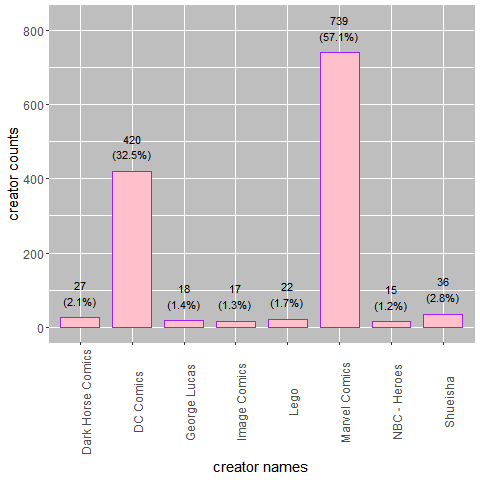

In [77]:
%%R -o superheroDataFilled

superheroDataFilled =
superheroDataFilled %>% filter(creator %in% c('Marvel Comics','DC Comics', 'Shueisha', 'Lego', 'Image Comics',
                                              'George Lucas', 'Dark Horse Comics', 'NBC - Heroes'))

creatorNamesandCounts = GetNamesandCounts(superheroDataFilled['creator'])


#create labels for new graph
labels = function(x)
{
    labels = unlist(round((x/sum(x))*100, 1)) %>% as.vector

    for(i in 1:length(labels))
    {
      labels[i] = paste0(toString(unlist(x)[i]), '\n(', labels[i], '%', ')' )
    }

    labels
}

labels = labels(creatorNamesandCounts['creator counts'])

ggplot(creatorNamesandCounts, aes(`creator names`, `creator counts`, label = labels)) +
       geom_bar(stat = "identity", fill = 'pink', color = "purple", width = 0.75) +
       theme(text = element_text(size=15), axis.text.x = element_text(angle = 90), panel.background = element_rect(fill = 'grey', color = 'grey')) +
       geom_text( vjust = -0.5, label.size = 0.15) +
       scale_y_continuous(limits = c(0, 825))



In [61]:
%%R -i categoricalVariablesFilled -o categoricalVariableNames

summaryTable = list()

categoricalVariableNames = categoricalVariablesFilled %>% colnames

for(i in 4:length(categoricalVariableNames))
{
    summaryTable[[i-3]] = superheroDataFilled[paste0(categoricalVariableNames[i])] %>% table
}

In [62]:
%%R -o summaryTable
summaryTable;

[[1]]
creator
Dark Horse Comics         DC Comics      George Lucas      Image Comics 
               27               420                18                17 
             Lego     Marvel Comics      NBC - Heroes          Shueisha 
               22               739                15                36 

[[2]]
alignment
    Bad    Good Neutral 
    416     764     114 

[[3]]
gender
Female   Male   None 
   335    957      2 

[[4]]
type_race
                   Alien                   Amazon                  Android 
                      30                        5                       18 
                  Animal                Asgardian                Atlantean 
                      24                       16                       10 
                 Bizarro               Bolovaxian               Centaurian 
                       2                        1                        1 
                   Clone            Cosmic Entity                   Cyborg 
                    

In [63]:
%%R -o SuperheroDataFilled

SuperheroDataFilled = superheroDataFilled %>% subset(gender != 'None'  )

In [ ]:
ProfileReport(SuperheroDataFilled)

In [ ]:
%%R -o raceNamesandCounts

getNamesandCounts = function(df, variable, variable_name)
{
    if(missing(variable_name))
    {
        variable_name = paste0(variable)
    }

    Counts = df[paste0(variable)] %>% table() %>% as.vector()

    Names = df[paste0(variable)] %>% unique() %>% unlist() %>% sort()

    NamesandCounts = data.frame(Names, Counts) %>% setNames(c(paste0(variable_name, ' names'), paste0(variable_name, ' counts')))
}

raceNamesandCounts = getNamesandCounts(SuperheroDataFilled, 'type_race', 'race')

eyeColorNameandCounts = getNamesandCounts(SuperheroDataFilled, 'eye_color', 'eye color')

hairColorNameandCounts = getNamesandCounts(SuperheroDataFilled, 'hair_color', 'hair color')

In [ ]:
%%R -o eyeColorNameandCounts
eyeColorNameandCounts = getNamesandCounts(SuperheroDataFilled, 'eye_color', 'eye color')

In [ ]:
%%R -o hairColorNameandCounts
hairColorNameandCounts = getNamesandCounts(SuperheroDataFilled, 'hair_color', 'hair color')

In [ ]:
px.bar(raceNamesandCounts, x ='race names', y ='race counts').show()
px.bar(eyeColorNameandCounts, x ='eye color names', y ='eye color counts').show()
px.bar(hairColorNameandCounts, x ='hair color names', y ='hair color counts').show()

In [78]:
%%R -o SuperheroDataFilled

SuperheroDataFilled =
SuperheroDataFilled %>% filter(type_race %in% c('Human', 'Mutant', 'Metahuman', 'God/Eternal',
                                              'Alien ', 'Animal', 'Asgardian', 'Android', 'Cyborg','Human/Radiation')) %>%
                        filter(eye_color %in% c('Blue', 'Black', 'Brown', 'Green', 'Red', 'White', 'Yellow')) %>%
                        filter(hair_color %in% c('Black', 'Blond', 'Brown', 'No Hair', 'Red', 'White', 'Grey', 'Green',
                                                'Strawberry', 'Auburn'))


In [ ]:
ProfileReport(SuperheroDataFilled)

In [ ]:
quantitativeVariables = superheroDataFilled.iloc[:, range(59,67)]

quantitativeVariables.corr()

In [ ]:
quantitativeVariables = SuperheroDataFilled.iloc[:, range(59,67)]

quantitativeVariables.corr()

In [ ]:
encodedVariables = superheroDataFilled.iloc[:, range(11,59)]

encodedVariables.corr()

In [ ]:
encodedVariables = SuperheroDataFilled.iloc[:, range(11,59)]

encodedVariables.corr()

KNN Analysis

In [89]:
%%R

ifmissing = function(x = NULL, value)
{
    if(is.null(x))
      return(value)
    else
        return(x)
}

KNN_SetUp = function(df, category, splitRatio, quantitativeVariableColumns)
{
    #do train/test split for initial model
    split = sample.split(df[category], SplitRatio = splitRatio)

    training_set = subset(df, split == TRUE)

    test_set = subset(df, split == FALSE)

    #scale quantitative variables to similar ranges
    train_scale <- scale(training_set[, quantitativeVariableColumns])
    test_scale <- scale(test_set[, quantitativeVariableColumns])

    return(list(train_scale, test_scale))
}

KNN_Analysis = function(df, category, initialSplitRatio, quantitativeVariableColumns, starting_k)
{
    initialSplitRatio = ifmissing(initialSplitRatio, 0.75)

    quantitativeVariableColumns = ifmissing(quantitativeVariableColumns, 10:67)

    starting_k = ifmissing(starting_k, 5)

    set.seed(123)

    temp = KNN_SetUp(df, category, initialSplitRatio, quantitativeVariableColumns)
    train_scale = temp[[1]]
    test_scale = temp[[2]]

    #find best k
    error_k = c()

    knnModels_VaryingK = vector(mode = 'list', length = 67)

    for(k in c(1:67))
    {
        classifier_knn <- knn(train = train_scale,
                              test = test_scale,
                              cl = training_set[category],
                              k = k)
        error_k[k] = mean(classifier_knn != test_set[category])
        knnModels_VaryingK[[i]] = classifier_knn
    }

    best_k = which.min(error_k)

    #find best split ratio
    errorSplitRatio = c()

    knnModels_VarySplitRatio = vector(mode = 'list', length = 99)

    for(i in 1:99)
    {
        temp = KNN_SetUp(df = df, category = category, splitRatio = i/100, quantitativeVariableColumns = quantitativeVariableColumns)
        train_scale = temp[[1]]
        test_scale = temp[[2]]

        if(train_scale %>% is.na %>% sum == 0 & test_scale %>% is.na %>% sum == 0)
        {
        classifier_knn <- knn(train = train_scale,
                                   test = test_scale,
                                   cl = training_set[category],
                                   k = best_k)

        errorSplitRatio[i] = mean(classifier_knn != test_set[category])
        knnModels_VarySplitRatio[[i]] = classifier_knn
        }
    }

    bestSplitRatio = which.min(errorSplitRatio)/100

    best_model = knnModels_VarySplitRatio[[bestSplitRatio*100]]

    confusionMatrix_bestModel <- table(df[category], best_model)

    return(list(error_k, knnModels_VaryingK, best_k, errorSplitRatio, knnModels_VarySplitRatio, bestSplitRatio, best_model, confusionMatrix_bestModel))
}


In [90]:
%%R
KNN_Analysis(superheroDataFilled, category = 'creator', initialSplitRatio = 0.5, quantitativeVariableColumns = 10:67, starting_k = 3)


R[write to console]: Error in knn(train = train_scale, test = test_scale, cl = training_set[category],  : 
  'train' and 'class' have different lengths




Error in knn(train = train_scale, test = test_scale, cl = training_set[category],  : 
  'train' and 'class' have different lengths


RInterpreterError: Failed to parse and evaluate line "KNN_Analysis(superheroDataFilled, category = 'creator', initialSplitRatio = 0.5, quantitativeVariableColumns = 10:67, starting_k = 3)\n\n".
R error message: "Error in knn(train = train_scale, test = test_scale, cl = training_set[category],  : \n  'train' and 'class' have different lengths"

In [ ]:
%%R
confusionMatrix <- table(test_set$creator, classifier_knn)
confusionMatrix

Cross-Validation

find best k value

In [ ]:
%%R -o error

error = c()

set.seed(123)

for(k in c(1:67))
{
    classifier_knn <- knn(train = train_scale,
                          test = test_scale,
                          cl = training_set$creator,
                          k = k)
    error[k] = mean(classifier_knn != test_set$creator)
}

error = error %>% as.data.frame %>% rename("error" = '.')

In [ ]:
error

find best split

In [ ]:
%%R -o error

set.seed(123)

error = c()

for(i in 1:99)
{
    split = sample.split(superheroDataFilled$creator, SplitRatio = i/100)

    training_set = subset(superheroDataFilled, split == TRUE)

    test_set = subset(superheroDataFilled, split == FALSE)

    #scale quantitative variables to similar ranges
    train_scale <- scale(training_set[, 10:67])
    test_scale <- scale(test_set[, 10:67])

    #create KNN model
    # noinspection PyRedundantParentheses

    if(train_scale %>% is.na %>% sum == 0 & test_scale %>% is.na %>% sum == 0)
    {
    classifier_knn <- knn(train = train_scale,
                               test = test_scale,
                               cl = training_set$creator,
                               k = 6)

    error[i] = mean(classifier_knn != test_set$creator)
    }
}

error = error
 %>% sort()
error

In [ ]:
type(error)